In [1]:
metadata_path = "../data/db2/MFD_metadatas.csv"
max_days = 365 * 3

In [2]:
from mandrillage.dataset import read_dataset, MandrillImageDataset
dataset = read_dataset(
    metadata_path,
    filter_dob_error=True,
    filter_certainty=False,
    max_age=max_days,
    max_dob_error=10,
    sex=None
)

/home/rkarpins/miniconda3/envs/mar/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


Filtered #-1897 (44729/46626)


In [3]:
from matplotlib import pyplot as plt
import cv2
import numpy as np

dataset_reader = MandrillImageDataset("../data/db2/Images",
        dataset,
        img_size=(224, 224),
        in_mem=False,
        max_days=365*0.5,
        individuals_ids=[],
        training=False)

def to_float(str_value):
    if "," in str_value:
        str_value = str_value.replace(",", ".")
    return float(str_value)

def f2i(f_value, scale=1):
    return int(f_value * scale)

def get_row_coords(row, x, y, scale_x, scale_y):
    return f2i(to_float(row[x]), scale_x), f2i(to_float(row[y]), scale_y)


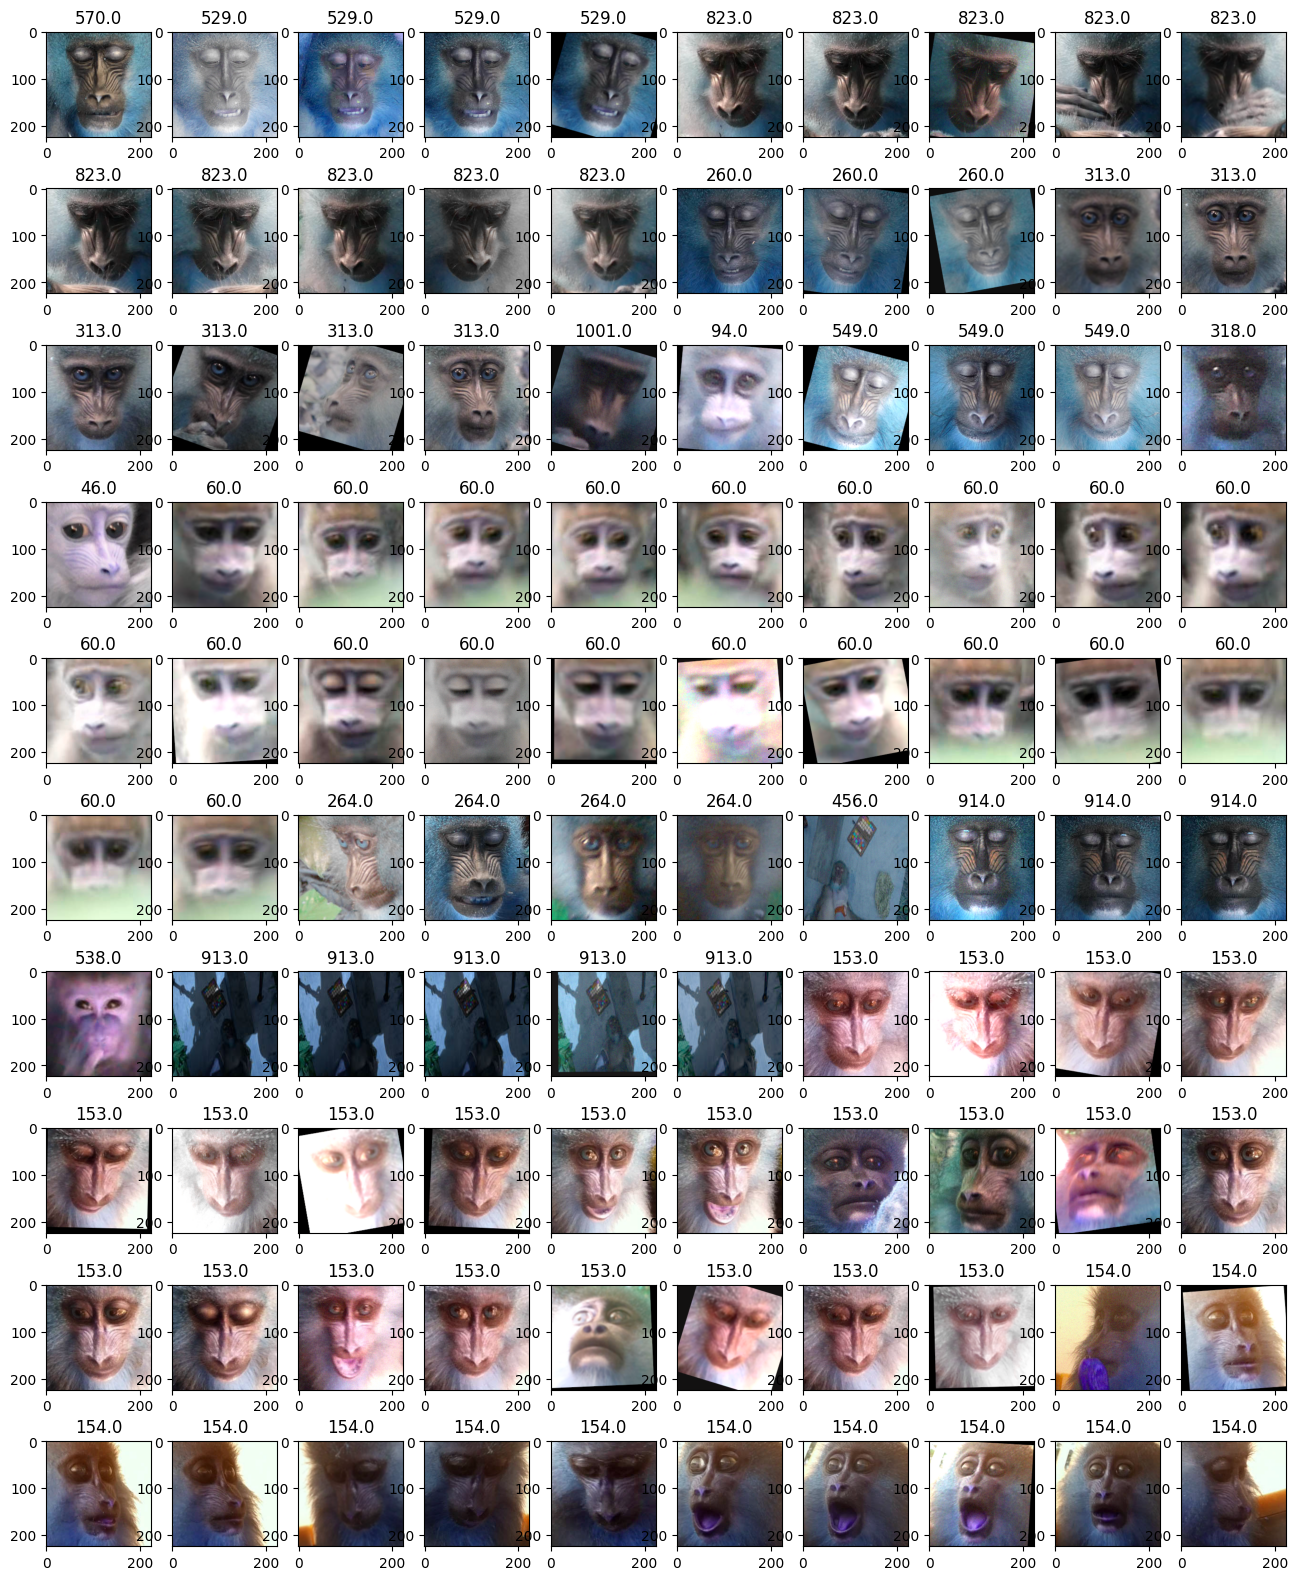

In [4]:
from mandrillage.dataset import AugmentedDataset
import numpy as np

augmented = AugmentedDataset(dataset_reader)

nrows = 10
ncols = 10
n_images = nrows * ncols
fig, axs = plt.subplots(nrows, ncols, figsize=(16,20))
for i in range(n_images):
    x, y = augmented[i]
    fig_row = i // ncols
    fig_col = i % ncols
    
    ax = axs[fig_row, fig_col] 
    ax.set_title(f"{y}")
    ax.imshow(np.moveaxis(x.numpy(), 0, -1))